# Milestone I Natural Language Processing
## Task 2&3


Date: 19th May 2024

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: 
* pandas
* re
* numpy
* json
* sklearn

## Introduction
In this digital world, job hunting is done through popular websites such as 'seek.com.au' and 'au.indeed.com'. These websites allow job searchers to search for their required positions using keywords, salaray ranges, company names, and job categories. From the sides of employers who post these jobs, the categorisation of job advertisements is done manually which often leads in jobs being incorrectly categorised and hence reducing their job visibility and their chance to gather suitable candidates.

With the goal to eliminate these issues, automated job classification systems incorporate Natural Language Processing (NLP) for increasing viability. These systems suggest suitable categories based on the textual content of the job advertisements, which increase accuracy by reducing human errors which in turn enhances the overall user experience on popular job hunting websites. The project aims to develop an automated job advertisement classification system though three key milestones. 

## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment

import pandas as pd
import numpy as np
import json
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

The objective of Task 2 is to generate three different types of feature representations for the job advertisement data. The primary focus of this task relies on the job description content and involves the following feature representations.

1. Count Vector from Bag-of-Words Model
* Generating the count vector representation for each job advertisement description using the vocabulary generated from the previous task 1.
* The generated count vector is daved into a file with the name 'count_vectors.txt' in the specified format.

2. Un-Weighted Vector Representation 
* Generating an un-weighted feature representation based on the choosen Glove embedding language model for each job advertisement description.

3. Weighted Vector Representation
* Generating a weighted feature representation (TF-IDF weighted) based on the Glove embedding for each job advertisement description.

From this Task 2, three feature representations are generated to store the textual information of job advertisements. The Bag-of-words model and word embedding models (both weighted and unweighted) are used in creating the representations. These deatures are utilised as a foundation for the classification models that are to be developed in Task 3.

In [2]:
# Loading job data from file
with open('jobs_data.txt', 'r', encoding='utf-8') as file:
    jobs = [json.loads(line.strip()) for line in file]

# Printing the length of jobs variable
print(f"Loaded {len(jobs)} job advertisements.")

# Loading vocabulary from vocab.txt
vocab = {}
with open('vocab1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        word, index = line.strip().split(':')
        vocab[word] = int(index)

# Printing the length of the vocabulary
print(f"Loaded vocabulary with {len(vocab)} words.")

Loaded 776 job advertisements.
Loaded vocabulary with 5168 words.


#### Generating the Count vector representation for each job advertisement description, and saving them into a file 

In [3]:
class CustomCountVectorizer(CountVectorizer):
    def __init__(self, vocabulary):
        super().__init__(vocabulary=vocabulary)
        self.fixed_vocab = vocabulary

    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: [word for word in analyzer(doc) if word in self.fixed_vocab]

# Creating the vectorizer using the fixed vocabulary
vectorizer = CustomCountVectorizer(vocabulary=vocab)
descriptions = [job['description'] for job in jobs]
X = vectorizer.fit_transform(descriptions)

# Printing the dimensions of the generated count vector on the provided vocabulary
print(f"Generated Count vectors with shape: {X.shape}")

Generated Count vectors with shape: (776, 5168)


In [4]:
# Printing the count vector
print(X)

  (0, 33)	3
  (0, 36)	3
  (0, 93)	1
  (0, 102)	1
  (0, 667)	1
  (0, 707)	1
  (0, 874)	1
  (0, 910)	1
  (0, 1003)	1
  (0, 1059)	2
  (0, 1145)	2
  (0, 1184)	1
  (0, 1221)	1
  (0, 1465)	1
  (0, 1484)	2
  (0, 1542)	1
  (0, 1706)	1
  (0, 1965)	1
  (0, 2113)	2
  (0, 2287)	1
  (0, 2652)	2
  (0, 2671)	1
  (0, 2750)	2
  (0, 2828)	1
  (0, 2998)	1
  :	:
  (775, 3700)	1
  (775, 3712)	1
  (775, 3822)	1
  (775, 3825)	1
  (775, 3943)	1
  (775, 3978)	1
  (775, 4108)	1
  (775, 4228)	1
  (775, 4245)	1
  (775, 4246)	1
  (775, 4250)	1
  (775, 4316)	1
  (775, 4362)	1
  (775, 4381)	2
  (775, 4400)	1
  (775, 4574)	1
  (775, 4606)	4
  (775, 4661)	1
  (775, 4769)	1
  (775, 4784)	1
  (775, 5031)	1
  (775, 5116)	1
  (775, 5135)	1
  (775, 5149)	1
  (775, 5158)	1


#### Generating Embedding Representations

In [5]:
# Loading the GloVe vectors 
glove_vectors = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vector

In [6]:
# Function to get the Unweighted and TF-IDF Weighted Vectors
def get_embedding_vector(words, glove_vectors, dimension=100):
    valid_vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    if not valid_vectors:
        return np.zeros(dimension)
    return np.mean(valid_vectors, axis=0)

In [7]:
unweighted_vectors = np.array([get_embedding_vector(description.split(), glove_vectors) for description in descriptions])
print("Unweighted vectors generated with shape:", unweighted_vectors.shape)

Unweighted vectors generated with shape: (776, 100)


In [8]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
X_tfidf = tfidf_vectorizer.fit_transform(descriptions)

In [9]:
# Function to get the weighted and TF-IDF Weighted Vectors
def get_weighted_embedding_vector(words, glove_vectors, tfidf_weights, dimension=100):
    weighted_vectors = [glove_vectors[word] * tfidf_weights[word] for word in words if word in glove_vectors and word in tfidf_weights]
    if not weighted_vectors:
        return np.zeros(dimension)
    return np.sum(weighted_vectors, axis=0)

In [10]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_weights = {word: X_tfidf.getcol(idx).sum() for idx, word in enumerate(tfidf_feature_names)}
weighted_vectors = np.array([get_weighted_embedding_vector(description.split(), glove_vectors, tfidf_weights) for description in descriptions])

print("Generated embedding vectors.")

Generated embedding vectors.


In [11]:
# Printing the unweighted feature vectors
print(unweighted_vectors)

[[-0.04912045  0.1376341   0.22746836 ... -0.34143266  0.62064427
   0.11939637]
 [-0.06473587  0.10273527  0.25368887 ... -0.35303521  0.70322967
   0.18740758]
 [-0.06994386  0.0646083   0.32060853 ... -0.27763915  0.69806057
   0.13404632]
 ...
 [-0.08307941  0.18765688  0.2116605  ... -0.34932116  0.69542122
   0.12397347]
 [-0.17813943  0.19519177  0.21691367 ... -0.36683658  0.61642939
   0.1164631 ]
 [-0.11345082  0.19725028  0.30904442 ... -0.32620427  0.60280424
   0.20378558]]


In [12]:
# Printing the weighted feature vectors
print(weighted_vectors)

[[   5.41078234   18.38315964   16.81437874 ...  -36.32561493
    63.68174362   -5.48943996]
 [  -3.44215202    8.61388683    3.97029996 ...  -25.54211426
    52.24055099    6.60615873]
 [  -1.84602094   31.83216476    9.18902683 ...  -40.07767487
    97.75092316   17.04796791]
 ...
 [  29.52369881   95.40268707  -16.31616592 ... -169.52568054
   408.30224609  181.97721863]
 [ -50.54840088   15.13054371   22.09374237 ...  -16.19872665
   159.48765564  -22.54460907]
 [   7.0368495    16.6568985    36.71109009 ...  -54.77024841
   138.07923889   27.94131851]]


### Saving outputs
Saving the count vector representation as per spectification.
- count_vectors.txt

In [13]:
# code to save output data
# Function to save the count vector generated in the provided format
def save_count_vectors(X, jobs, vocab, output_file):
    reverse_vocab = {v: k for k, v in vocab.items()}  
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for idx, row in enumerate(X):
            row = row.tocoo()
            counts = {reverse_vocab[i]: row.data[j] for j, i in enumerate(row.col)}
            counts_str = ', '.join(f"{vocab[word]}:{counts[word]}" for word in sorted(counts.keys(), key=lambda x: vocab[x]))
            f.write(f"#{jobs[idx]['webIndex']}, {counts_str}\n")

In [14]:
# Saving to count_vectors.txt
save_count_vectors(X, jobs, vocab, 'count_vectors.txt')
print("Count vectors saved to count_vectors.txt")

Count vectors saved to count_vectors.txt


## Task 3. Job Advertisement Classification

The task 3 focuses on building and evaluating ML models for classifying the category of the pre-processed advertisements. The two main parts of this task and research questions addressed are discussed below.

Question 1:
* Objective: To determine which among the three language models generated in task 2 performs the best when trained on the Logistic Regression ML model
* Approach: The count vector, unweighted embedding vector, and TF-IDF weighted embedding vectors generated in the task 2 are used to train and evaluate the job data
* Evaluation: The 5-fold cross-validation are utilised to evaluate the perfromance of each model

Question 2:
* Objective: To explore whether additional information such as adding the job title improves the classification accuracy of the model.
* Approach: Conducting an experiment using three different feature sets mentioned below:
    * Only job title
    * Only the job description
    * Both the job title and description
* Evaluation: The 5-fold cross-validation is used to compare the performance of models built with different feature sets

The finding from this task provide insights to effectiveness of the three different feature representations and the advantages of concatenating additional job-related information.

In [15]:
# Extracting the labels
labels = [job['targetLabel'] for job in jobs]

# Spliting the data for training and testing
X_train_count, X_test_count, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train_unweighted, X_test_unweighted = train_test_split(unweighted_vectors, test_size=0.2, random_state=42)
X_train_weighted, X_test_weighted = train_test_split(weighted_vectors, test_size=0.2, random_state=42)

In [16]:
# Function to train and evaluate model with scaling
def train_evaluate_model(X, y, max_iter=5000, solver='saga'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=max_iter, random_state=42, solver=solver))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, pipeline, X_test, y_test, y_pred

#### Q1

The results of accuracy from training the data on logistic regression model gave rise to the following values:
* count vector : 85%
* unweighted embedding vector : 78%
* weighted embedding vector : 70%

Further to evaluate these vectors, the 5-fold cross validation method is utilised to bring in the improved values below:
* count vector : 87%
* unweighted embedding vector : 78%
* weighted embedding vector : 71%

From analysing the confusion metrix and the evaluation values, it is decided that the count vector much be used for the next section of this task due to its high performance amongst the other representations.

The code explaining the above observations is displayed below.

In [17]:
# Evaluating the Count Vectors
accuracy_count, model_count, X_test_count, y_test_count, y_pred_count = train_evaluate_model(X, labels)
print(f"Accuracy using Count Vectors: {accuracy_count}")

# Evaluating the Unweighted Embedding Vectors
accuracy_unweighted, model_unweighted, X_test_unweighted, y_test_unweighted, y_pred_unweighted = train_evaluate_model(unweighted_vectors, labels)
print(f"Accuracy using Unweighted Embedding Vectors: {accuracy_unweighted}")

# Evaluating the TF-IDF Weighted Embedding Vectors
accuracy_weighted, model_weighted, X_test_weighted, y_test_weighted, y_pred_weighted = train_evaluate_model(weighted_vectors, labels)
print(f"Accuracy using TF-IDF Weighted Embedding Vectors: {accuracy_weighted}")

Accuracy using Count Vectors: 0.8589743589743589
Accuracy using Unweighted Embedding Vectors: 0.7884615384615384
Accuracy using TF-IDF Weighted Embedding Vectors: 0.7051282051282052


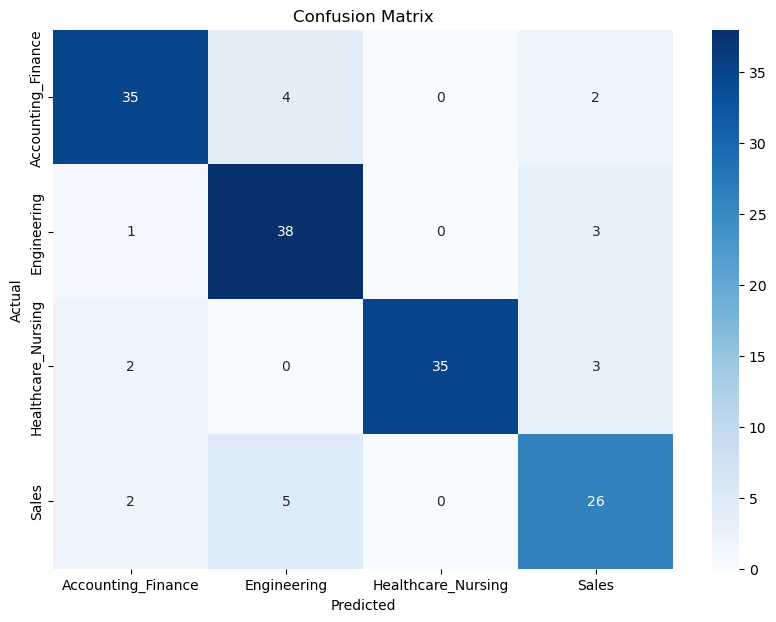

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to plot the confusion matrix for one of the models
def plot_confusion_matrix(y_test, y_pred, labels):
    conf_mat = confusion_matrix(y_test, y_pred)
    categories = sorted(list(set(labels)))  
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Ploting confusion matrix for the count vector model
plot_confusion_matrix(y_test_count, y_pred_count, labels)

In [19]:
# Initialising the variables
seed = 15
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Defining the evaluation function
def evaluate(X_train, X_test, y_train, y_test, seed, max_iter=5000, solver='saga'):
    pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(random_state=seed, max_iter=max_iter, solver=solver))
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_test, y_test)

# Creating a DataFrame to store results
cv_df = pd.DataFrame(columns=['count', 'unweighted', 'tfidf'], index=range(num_folds))

# Performing 5-fold cross-validation
fold = 0
for train_index, test_index in kf.split(list(range(0, len(labels)))):
    y_train = [labels[i] for i in train_index]
    y_test = [labels[i] for i in test_index]

    # Evaluating the Count Vectors
    X_train_count, X_test_count = X[train_index], X[test_index]
    cv_df.loc[fold, 'count'] = evaluate(X_train_count, X_test_count, y_train, y_test, seed)
    
    # Evaluating the Unweighted Embedding Vectors
    X_train_unweighted, X_test_unweighted = unweighted_vectors[train_index], unweighted_vectors[test_index]
    cv_df.loc[fold, 'unweighted'] = evaluate(X_train_unweighted, X_test_unweighted, y_train, y_test, seed)
    
    # Evaluating the TF-IDF Weighted Embedding Vectors
    X_train_tfidf, X_test_tfidf = weighted_vectors[train_index], weighted_vectors[test_index]
    cv_df.loc[fold, 'tfidf'] = evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test, seed)
    
    fold += 1

In [20]:
# Printing the results
cv_df

,count,unweighted,tfidf
0,0.858974,0.801282,0.724359
1,0.890323,0.76129,0.741935
2,0.864516,0.774194,0.690323
3,0.883871,0.76129,0.677419
4,0.858065,0.819355,0.76129


In [21]:
# Printing the mean results
cv_df.mean()

count         0.871150
unweighted    0.783482
tfidf         0.719065
dtype: float64

#### Q2
By exploring how the count vector represenation is working on different kinds of data such as only titles, only descriptions, and the combined title and descriptions, the following values have been derived based on their accuracies.
* Titles only : 80%
* Descriptions only : 87%
* Both titles and descriptions : 86%

These accuracy results show that the descriptions alone and the combined titles and descriptions show a higher rate of accuracy that that of the titles alone. Futher exploration shows that the description data alone has the highest accuracy in prediction with the performance model. The resultant observations are:
* Titles data alone does not work best of the performance of the ML model.
* Descriptions only and the combined title and description data show almost similar performance whereas the descriptions only performs better by 1% of accuracy.
* This concludes that having extra information does help in boosting the model performance however this might be true in all the cases.

The steps below show the code to the observations gained.

In [22]:
# Extracting titles, descriptions, and combined text
titles = [job['title'] for job in jobs]
descriptions = [job['description'] for job in jobs]
combined_texts = [job['title'] + ' ' + job['description'] for job in jobs]
labels = [job['targetLabel'] for job in jobs]

# Initialising CountVectorizer
vectorizer = CountVectorizer()

# Generating Count Vectors
X_titles = vectorizer.fit_transform(titles)
X_descriptions = vectorizer.fit_transform(descriptions)
X_combined = vectorizer.fit_transform(combined_texts)

print(f"Title vectors shape: {X_titles.shape}")
print(f"Description vectors shape: {X_descriptions.shape}")
print(f"Combined vectors shape: {X_combined.shape}")


Title vectors shape: (776, 989)
Description vectors shape: (776, 9935)
Combined vectors shape: (776, 10000)


In [23]:
# Initialising the variables
seed = 15
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Defining the evaluation function
def evaluate(X_train, X_test, y_train, y_test, seed, max_iter=5000, solver='saga'):
    pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(random_state=seed, max_iter=max_iter, solver=solver))
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_test, y_test)

# Creating a DataFrame to store results
cv_df = pd.DataFrame(columns=['titles', 'descriptions', 'combined'], index=range(num_folds))

# Performing 5-fold cross-validation
fold = 0
for train_index, test_index in kf.split(list(range(0, len(labels)))):
    y_train = [labels[i] for i in train_index]
    y_test = [labels[i] for i in test_index]

    # Evaluating Title Vectors
    X_train_titles, X_test_titles = X_titles[train_index], X_titles[test_index]
    cv_df.loc[fold, 'titles'] = evaluate(X_train_titles, X_test_titles, y_train, y_test, seed)
    
    # Evaluating Description Vectors
    X_train_descriptions, X_test_descriptions = X_descriptions[train_index], X_descriptions[test_index]
    cv_df.loc[fold, 'descriptions'] = evaluate(X_train_descriptions, X_test_descriptions, y_train, y_test, seed)
    
    # Evaluating Combined Vectors
    X_train_combined, X_test_combined = X_combined[train_index], X_combined[test_index]
    cv_df.loc[fold, 'combined'] = evaluate(X_train_combined, X_test_combined, y_train, y_test, seed)
    
    fold += 1

In [24]:
# Displaying the results
print(cv_df)

     titles descriptions  combined
0  0.801282     0.852564  0.858974
1       0.8     0.883871  0.890323
2  0.825806     0.877419  0.870968
3  0.787097     0.883871  0.877419
4  0.793548     0.858065  0.851613


In [25]:
# Displaying the mean of results
print(cv_df.mean())

titles          0.801547
descriptions    0.871158
combined        0.869859
dtype: float64


## Summary
The aim of this project through tasks 2 and 3, aim to improve the process of job advertisement classification using NLP techniques. This includes generation of diverse feature representations and evaluation of the classification models with the goal to improve the accuracy and efficiency of job classsification on job hunting platforms. These insights contibute to the development of robust automated job classification system, benefitting both job seekers and employers by providing better job matching and visibility.